<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/Thyroid_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification based on the Thyroid Disease Dataset

In [ ]:
! pip install pandas-profiling==3.2.0

In [ ]:
! pip install markupsafe==2.0.1

Importing necessary libraries:

In [ ]:
%matplotlib inline

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, datasets
import plotly.express as px
import imblearn
from pandas_profiling import ProfileReport
from collections import Counter

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from imblearn.pipeline import Pipeline as imb_pipe
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

Loading data:

In [ ]:
df = pd.read_csv('./dataset_57_hypothyroid.csv')

Setting global constants:

In [ ]:
SEED = 844
TARGET = 'Class'

# EDA

In [ ]:
df.head().T

0         1         2         3         4
age                              41        23        46        70        70
sex                               F         F         M         F         F
on_thyroxine                      f         f         f         t         f
query_on_thyroxine                f         f         f         f         f
on_antithyroid_medication         f         f         f         f         f
sick                              f         f         f         f         f
pregnant                          f         f         f         f         f
thyroid_surgery                   f         f         f         f         f
I131_treatment                    f         f         f         f         f
query_hypothyroid                 f         f         f         f         f
query_hyperthyroid                f         f         f         f         f
lithium                           f         f         f         f         f
goitre                            f         f         f         f         f
tumor                             f         f         f         f         f
hypopituitary                     f         f         f         f         f
psych                             f         f         f         f         f
TSH_measured                      t         t         t         t         t
TSH                             1.3       4.1      0.98      0.16      0.72
T3_measured                       t         t         f         t         t
T3                              2.5         2         ?       1.9       1.2
TT4_measured                      t         t         t         t         t
TT4                             125       102       109       175        61
T4U_measured                      t         f         t         f         t
T4U                            1.14         ?      0.91         ?      0.87
FTI_measured                      t         f         t         f         t
FTI                             109         ?       120         ?        70
TBG_measured                      f         f         f         f         f
TBG                               ?         ?         ?         ?         ?
referral_source                SVHC     other     other     other       SVI
Class                      negative  negative  negative  negative  negative

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [ ]:
df['age'].unique()

array(['41', '23', '46', '70', '18', '59', '80', '66', '68', '84', '67',
       '71', '28', '65', '42', '63', '51', '81', '54', '55', '60', '25',
       '73', '34', '78', '37', '85', '26', '58', '64', '44', '48', '61',
       '35', '83', '21', '87', '53', '77', '27', '69', '74', '38', '76',
       '45', '36', '22', '43', '72', '82', '31', '39', '49', '62', '57',
       '1', '50', '30', '29', '75', '19', '7', '79', '17', '24', '15',
       '32', '47', '16', '52', '33', '13', '10', '89', '56', '20', '90',
       '40', '88', '14', '86', '94', '12', '4', '11', '8', '5', '455',
       '2', '91', '6', '?', '93', '92'], dtype=object)

In [ ]:
(df['age']=='?').sum()

1

In [ ]:
df.drop(df[df['age']=='?'].index, inplace=True)
df.drop(df[df['age']=='455'].index, inplace=True)

In [ ]:
df['age'] = df['age'].astype(int)

In [ ]:
df['sex'].unique()

array(['F', 'M', '?'], dtype=object)

In [ ]:
(df['sex']=='?').sum()

150

In [ ]:
df['thyroid_surgery'].unique()

array(['f', 't'], dtype=object)

In [ ]:
df['referral_source'].unique()

array(['SVHC', 'other', 'SVI', 'STMW', 'SVHD'], dtype=object)

In [ ]:
df['referral_source'].value_counts()

other    2200
SVI      1033
SVHC      386
STMW      112
SVHD       39
Name: referral_source, dtype: int64

In [ ]:
df.drop(['referral_source'], axis=1, inplace=True)

Dividing columns for numeric, boolean, and categorical using three lists of their names. Replacing default values of boolean variables ('f' and 't') with 0 and 1:

In [ ]:
bool_cols = list(df.select_dtypes(object))
categorical_cols = ['sex']
numeric_cols = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
bool_cols = [el for el in bool_cols if el not in categorical_cols and el not in numeric_cols and el != TARGET]
bool_cols
for column in bool_cols:
  df[column]=df[column].replace('f','0')
  df[column]=df[column].replace('t','1')
  df[column] = df[column].astype('int32')

In [ ]:
bool_cols

['on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_medication',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'hypopituitary',
 'psych',
 'TSH_measured',
 'T3_measured',
 'TT4_measured',
 'T4U_measured',
 'FTI_measured',
 'TBG_measured']

In [ ]:
df = df.replace('?', np.nan)

Converting type of continuous columns to float.

In [ ]:
for column in numeric_cols:
  df[column] = df[column].astype(float)

I assume '..._measured' columns as redundant because their values are highly correlated with columns containing numeric parameters and most importantly from my point of view these values give nothing in order to predict the outcome as they are just markers of whether another parameter was measured or not. So I just drop them:


In [ ]:
dropped_cols = set()
for column in bool_cols:
  if column.find('_measured') != -1:
    df.drop([column], axis=1, inplace=True)
    dropped_cols.add(column)
for i in dropped_cols:
  bool_cols.remove(i)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3770 entries, 0 to 3771
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3770 non-null   int64  
 1   sex                        3620 non-null   object 
 2   on_thyroxine               3770 non-null   int32  
 3   query_on_thyroxine         3770 non-null   int32  
 4   on_antithyroid_medication  3770 non-null   int32  
 5   sick                       3770 non-null   int32  
 6   pregnant                   3770 non-null   int32  
 7   thyroid_surgery            3770 non-null   int32  
 8   I131_treatment             3770 non-null   int32  
 9   query_hypothyroid          3770 non-null   int32  
 10  query_hyperthyroid         3770 non-null   int32  
 11  lithium                    3770 non-null   int32  
 12  goitre                     3770 non-null   int32  
 13  tumor                      3770 non-null   int32

In [ ]:
df['Class'].unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

In [ ]:
df['Class'].value_counts()

negative                   3479
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

In [ ]:
df_mc = df.copy()

I decided to join three positive target classes into one and perform a binary classification task because we have very little data in two of them.

In [ ]:
df.loc[df[TARGET]=='compensated_hypothyroid', TARGET] = 1
df.loc[df[TARGET]=='primary_hypothyroid', TARGET] = 1
df.loc[df[TARGET]=='secondary_hypothyroid', TARGET] = 1
df.loc[df[TARGET]=='negative', TARGET] = 0

In [ ]:
df['Class'].value_counts()

0    3479
1     291
Name: Class, dtype: int64

In [ ]:
df[TARGET] = df[TARGET].astype('int32')

In [ ]:
df.describe()

age  on_thyroxine  query_on_thyroxine  \
count  3770.000000   3770.000000         3770.000000   
mean     51.628912      0.122812            0.013263   
std      18.982990      0.328264            0.114412   
min       1.000000      0.000000            0.000000   
25%      36.000000      0.000000            0.000000   
50%      54.000000      0.000000            0.000000   
75%      67.000000      0.000000            0.000000   
max      94.000000      1.000000            1.000000   

       on_antithyroid_medication         sick     pregnant  thyroid_surgery  \
count                3770.000000  3770.000000  3770.000000      3770.000000   
mean                    0.011406     0.038992     0.014058         0.014058   
std                     0.106201     0.193602     0.117747         0.117747   
min                     0.000000     0.000000     0.000000         0.000000   
25%                     0.000000     0.000000     0.000000         0.000000   
50%                     0.000000     0.000000     0.000000         0.000000   
75%                     0.000000     0.000000     0.000000         0.000000   
max                     1.000000     1.000000     1.000000         1.000000   

       I131_treatment  query_hypothyroid  query_hyperthyroid  ...  \
count     3770.000000        3770.000000         3770.000000  ...   
mean         0.015385           0.062069            0.062865  ...   
std          0.123093           0.241313            0.242752  ...   
min          0.000000           0.000000            0.000000  ...   
25%          0.000000           0.000000            0.000000  ...   
50%          0.000000           0.000000            0.000000  ...   
75%          0.000000           0.000000            0.000000  ...   
max          1.000000           1.000000            1.000000  ...   

             tumor  hypopituitary        psych          TSH           T3  \
count  3770.000000    3770.000000  3770.000000  3401.000000  3001.000000   
mean      0.025464       0.000265     0.048806     5.089258     2.013675   
std       0.157551       0.016287     0.215492    24.528465     0.827657   
min       0.000000       0.000000     0.000000     0.005000     0.050000   
25%       0.000000       0.000000     0.000000     0.500000     1.600000   
50%       0.000000       0.000000     0.000000     1.400000     2.000000   
75%       0.000000       0.000000     0.000000     2.700000     2.400000   
max       1.000000       1.000000     1.000000   530.000000    10.600000   

               TT4          T4U          FTI  TBG        Class  
count  3539.000000  3383.000000  3385.000000  0.0  3770.000000  
mean    108.313309     0.995012   110.461064  NaN     0.077188  
std      35.613396     0.195478    33.093651  NaN     0.266925  
min       2.000000     0.250000     2.000000  NaN     0.000000  
25%      87.500000     0.880000    93.000000  NaN     0.000000  
50%     103.000000     0.980000   107.000000  NaN     0.000000  
75%     124.000000     1.080000   124.000000  NaN     0.000000  
max     430.000000     2.320000   395.000000  NaN     1.000000  

[8 rows x 22 columns]

The 'TGB' column has no data in it so I drop this feature.

In [ ]:
df.drop(['TBG'], axis=1, inplace=True)
numeric_cols.remove('TBG')

Using PandasProfiling to get more detailed description of the data:

In [ ]:
profile = ProfileReport(df)

In [ ]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Profiling Report shows a few things about the data:
1. We don't have variables highly correlated with the target and also with each other.
2. All the continuous variables are normally distributed but some of them have distinct outliers.
3. We have a lot of missing data in continuous variables which we must deal with.   

I use a stacked barplot for the categorical variable to find out if there is a correlation between it and the target:

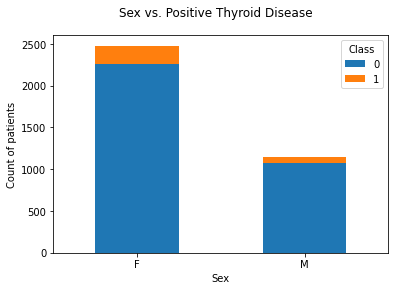

In [ ]:
counts_df = df.groupby(["sex", "Class"])["sex"].count().unstack()
fig, ax = plt.subplots()

counts_df.plot(kind="bar", stacked=True, ax=ax)
plt.xticks(rotation = 0)
ax.set_ylabel("Count of patients")

ax.set_xlabel("Sex")

fig.suptitle("Sex vs. Positive Thyroid Disease");

From this plot, I couldn't see a significant correlation between sex and a positive diagnosis. Proportions for males and for females seem very similar.

I'm going to plot multiple histograms for all numeric variables. It will help to compare distributions of 'positive' and 'negative' cases of the target, and visually distingwish if there is a correlation between the variable and the target.  

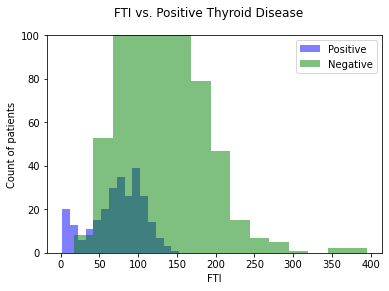

In [ ]:
fig, ax = plt.subplots()

ax.hist(df[df[TARGET]==1]["FTI"], bins=15, alpha=0.5, color="blue", label="Positive")
ax.hist(df[df[TARGET]==0]["FTI"], bins=15, alpha=0.5, color="green", label="Negative")

ax.set_xlabel("FTI")
ax.set_ylabel("Count of patients")
plt.ylim([0,100])
fig.suptitle("FTI vs. Positive Thyroid Disease")

ax.legend();

For 'FTI' we can see a correlation - positive cases of thyroid disease characterized by lower values of this parameter and extremely low values 100% guarantee positive outcome of the target.

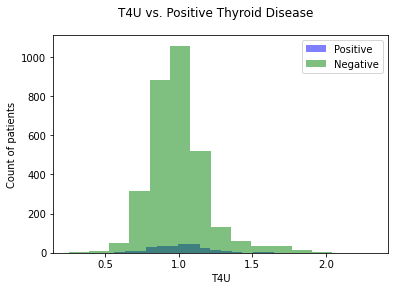

In [ ]:
fig, ax = plt.subplots()

ax.hist(df[df[TARGET]==1]["T4U"], bins=15, alpha=0.5, color="blue", label="Positive")
ax.hist(df[df[TARGET]==0]["T4U"], bins=15, alpha=0.5, color="green", label="Negative")

ax.set_xlabel("T4U")
ax.set_ylabel("Count of patients")
#plt.ylim([0,100])
fig.suptitle("T4U vs. Positive Thyroid Disease")

ax.legend();

Here, with t4U, we have very similar distributions between positive and negative values of the target so I assume there is no significant correlation between the target and this parameter.

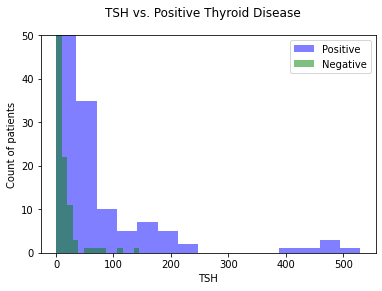

In [ ]:
fig, ax = plt.subplots()

ax.hist(df[df[TARGET]==1]["TSH"], bins=15, alpha=0.5, color="blue", label="Positive")
ax.hist(df[df[TARGET]==0]["TSH"], bins=15, alpha=0.5, color="green", label="Negative")

ax.set_xlabel("TSH")
ax.set_ylabel("Count of patients")
plt.ylim([0,50])
fig.suptitle("TSH vs. Positive Thyroid Disease")

ax.legend();

'TSH' is the second parameter that we can confidently recognize as significantly correlated with the target variable. On the plot, we can see that higher values of TSH designate a higher probability of thyroid disease and extremely high values are a 100% marker of a positive diagnosis.

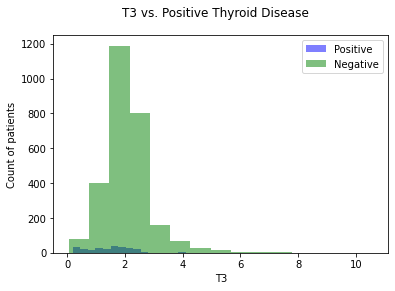

In [ ]:
fig, ax = plt.subplots()

ax.hist(df[df[TARGET]==1]["T3"], bins=15, alpha=0.5, color="blue", label="Positive")
ax.hist(df[df[TARGET]==0]["T3"], bins=15, alpha=0.5, color="green", label="Negative")

ax.set_xlabel("T3")
ax.set_ylabel("Count of patients")
#plt.ylim([0,500])
fig.suptitle("T3 vs. Positive Thyroid Disease")

ax.legend();

Based on the shapes of the distribution curves I would say that there is a correlation between 'T3' and the target. Smaller values of this parameter have a bigger proportion toward the positive outcome.  

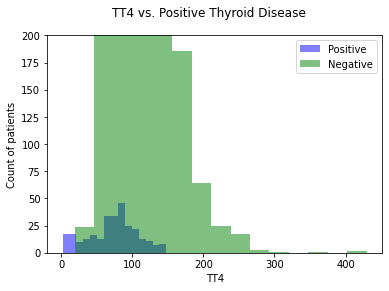

In [ ]:
fig, ax = plt.subplots()

ax.hist(df[df[TARGET]==1]["TT4"], bins=15, alpha=0.5, color="blue", label="Positive")
ax.hist(df[df[TARGET]==0]["TT4"], bins=15, alpha=0.5, color="green", label="Negative")

ax.set_xlabel("TT4")
ax.set_ylabel("Count of patients")
plt.ylim([0,200])
fig.suptitle("TT4 vs. Positive Thyroid Disease")

ax.legend();

Here again, we see a correlation - lower values of 'TT4'causes a higher probability of thу positive diagnosis, and extremely low values 100% guarantee a positive diagnosis. And we also see that this plot looks very similar to the histogram of 'FTI' so probably these parameters are highly correlated with each other.

# Data Preprocessing

The next step is data preprocessing which includes the imputation of missing data, normalization of continuous variables, encoding of categorical variables, and preparing the dataset to further fitting of classification models. <br>
For the numeric features I choose IterativeImputer which is able to impute missing values based on the values of the other columns of the data, so imputed data probably will have bigger quality than if we would just impute them with the mean or the median.<br> I also scale all the continuous features with StandardScaler.   

In [ ]:
iter_imputer = IterativeImputer(random_state=SEED)
scaler = StandardScaler()
iter_imputed = iter_imputer.fit_transform(df[numeric_cols])
num_scaled = scaler.fit_transform(iter_imputed)
df_num_imputed = pd.DataFrame(num_scaled, columns=numeric_cols)

/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


For the categorical feature (we have only the one - 'sex') I am going to impute missing values with the constant value of 'M' because as I found out during EDA that sex doesn't correlate much with the target and also number of missing values is not so big (~4%) so I assume this imputing won't affect much to the result of models we are going to train.  <br>
Here I also use One Hot Encoder with the enabled option of dropping the first of the encoded columns in order to prevent multicollinearity issues.

In [ ]:
cat_imputer = SimpleImputer(strategy='constant', fill_value='M')
cat_encoder = OneHotEncoder(drop='first',sparse=False)
cat_imputed = cat_imputer.fit_transform(df[categorical_cols])
cat_encoded = cat_encoder.fit_transform(cat_imputed)
df_cat_imputed = pd.DataFrame(cat_encoded, columns=categorical_cols, dtype='int32')

Finally, I use Simple Imputer for boolean variables. This part is mainly for the unification of the preprocessing pipeline because actually there is nothing to impute in booleans as far as I remember.    

In [ ]:
bool_imputer = SimpleImputer(strategy='constant', fill_value=0)
bool_imputed = bool_imputer.fit_transform(df[bool_cols])
df_bool_imputed = pd.DataFrame(bool_imputed, columns=bool_cols)

Stacking features of different types into the one DataFrame. This will be our X:

In [ ]:
X = pd.concat([df_cat_imputed, df_bool_imputed, df_num_imputed], axis = 1)

In [ ]:
X

sex  on_thyroxine  query_on_thyroxine  on_antithyroid_medication  sick  \
0       0             0                   0                          0     0   
1       0             0                   0                          0     0   
2       1             0                   0                          0     0   
3       0             1                   0                          0     0   
4       0             0                   0                          0     0   
...   ...           ...                 ...                        ...   ...   
3765    0             0                   0                          0     0   
3766    0             0                   0                          0     0   
3767    0             0                   0                          0     0   
3768    1             0                   0                          0     0   
3769    0             0                   0                          0     0   

      pregnant  thyroid_surgery  I131_treatment  query_hypothyroid  \
0            0                0               0                  0   
1            0                0               0                  0   
2            0                0               0                  0   
3            0                0               0                  0   
4            0                0               0                  0   
...        ...              ...             ...                ...   
3765         0                0               0                  0   
3766         0                0               0                  0   
3767         0                0               0                  0   
3768         0                0               0                  0   
3769         0                0               0                  0   

      query_hyperthyroid  lithium  goitre  tumor  hypopituitary  psych  \
0                      0        0       0      0              0      0   
1                      0        0       0      0              0      0   
2                      0        0       0      0              0      0   
3                      0        0       0      0              0      0   
4                      0        0       0      0              0      0   
...                  ...      ...     ...    ...            ...    ...   
3765                   0        0       0      1              0      0   
3766                   0        0       0      0              0      0   
3767                   1        0       0      0              0      0   
3768                   0        0       0      0              0      0   
3769                   0        0       0      0              0      0   

               TSH            T3           TT4           T4U           FTI  
0    -1.605931e-01  6.288458e-01  4.833248e-01  7.844031e-01 -3.372733e-02  
1    -4.074648e-02 -2.616229e-02 -1.831544e-01 -4.951001e-02 -1.672536e-01  
2    -1.742899e-01 -1.053280e-01  1.968710e-02 -4.547221e-01  3.113512e-01  
3    -2.093879e-01 -1.571639e-01  1.932193e+00  3.355889e-01  1.843045e+00  
4    -1.854185e-01 -1.074175e+00 -1.371226e+00 -6.702221e-01 -1.257188e+00  
...            ...           ...           ...           ...           ...  
3765 -8.743715e-16  3.548761e-14  3.953213e-14  5.263568e-14  6.241278e-15  
3766 -1.734339e-01  1.048393e-01  4.543475e-01  4.611531e-01  1.231266e-01  
3767  2.055906e-03 -2.881655e-01  1.066192e-01  4.072781e-01 -1.592104e-01  
3768 -1.862746e-01 -2.616229e-02 -7.627016e-01 -2.930971e-01 -7.238844e-01  
3769 -1.734339e-01  2.358409e-01 -2.700865e-01  4.072781e-01 -5.670305e-01  

[3770 rows x 20 columns]

Assigning the target column to 'y':

In [ ]:
y = df[TARGET]

In [ ]:
counter = Counter(y)
counter

Counter({0: 3479, 1: 291})

We see here that our dataset is quite imbalanced - the number of negative outcomes is 12 times higher than positive ones. So the models trained on such a dataset could perform worse than if the dataset was balanced.  

As the last step in data preparation, I will split the dataset into the train and test parts for further processing with classification models:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, shuffle=True, test_size=0.2)
columns = X_train.columns
col_y = ['Class']

In [ ]:
counter = Counter(y_train)
counter

Counter({0: 2782, 1: 234})

# Logistic Regression without SMOTE

As a baseline, I will train the Logistic Regression model with the unbalanced data which was given initially. Then I will try to improve the model's performance by balancing the dataset.

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


Looking at the Confusion Matrix that we get by comparing predictions of the model and actual target values in the test dataset we can see that there are a lot of false negatives (33) which is totally unacceptable in our case, as they are actually patients who will get a negative diagnosis whereas they actually have the thyroid decease. Using this intuition I would say that the recall metric is what I need to use while estimating the models' performance further. As an alternative, I could also use the F1 metric as it is a combination of recall and precision.  

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[691,   6],
       [ 33,  24]])

As we can see in the report below we got quite good results (all metrics) with negative cases and much worse with positive ones. This is because of the huge imbalance in our train dataset.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       697
           1       0.80      0.42      0.55        57

    accuracy                           0.95       754
   macro avg       0.88      0.71      0.76       754
weighted avg       0.94      0.95      0.94       754



# Using SMOTE for oversampling the minority class

In order to improve the performance of the Logistic regression model I will use Synthetic Minority Oversampling Technique (SMOTE). It will help to add additional synthetic points of the minority class and make the dataset more balanced. As per the article I've read it works better along with the technique which randomly drops some rows from the majority class (RandomUnderSampler) so I decided to use it also.

In [ ]:
# define pipeline
over = SMOTE(sampling_strategy=0.5, k_neighbors=3)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('over', over), ('under', under)]
pipeline = imb_pipe(steps=steps)

In [ ]:
# evaluate pipeline
train_X, train_y = pipeline.fit_resample(X_train, y_train)
counter = Counter(train_y)
counter

Counter({0: 2782, 1: 1391})

Now we've got a much more balanced dataset with the ratio of negative and positive classes of 2:1

In [ ]:
train_X = pd.DataFrame(data=train_X,columns=columns )
train_y = pd.DataFrame(data=train_y,columns=col_y)

In [ ]:
train_y[TARGET].unique()

array([0, 1], dtype=int32)

Fitting the LR model (without regularisation) using the balanced dataset:

In [ ]:
model = LogisticRegression(penalty='none', solver='newton-cg')
model.fit(train_X, train_y)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(penalty='none', solver='newton-cg')

Predicting using the model and outputting the accuracy:

In [ ]:
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


Building the confusion matrix:

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[675,  22],
       [ 10,  47]])

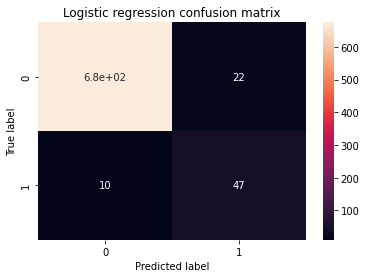

In [ ]:
sns.heatmap(cm,
            annot=cm,
            yticklabels=train_y[TARGET].unique(),
            xticklabels=train_y[TARGET].unique());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

From the confusion matrix, we can see that the number of false negatives was reduced but the proportion between true positives and false negatives is still high which will cause a low recall.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       697
           1       0.68      0.82      0.75        57

    accuracy                           0.96       754
   macro avg       0.83      0.90      0.86       754
weighted avg       0.96      0.96      0.96       754



From the classification report, we can see that recall, and also f1 for the positive class were improved in comparison with the model trained with the unbalanced dataset. But metrics are still not perfect.  

Next I am going to plot ROC curve ant check the ROC AUC value.  

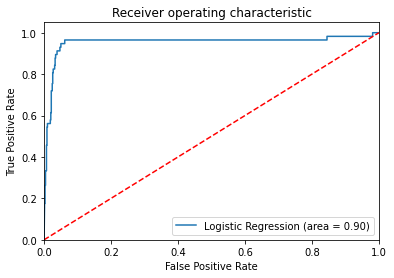

In [ ]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Our model gives us a ROC AUC value of 0.9 which is quite good but again not perfect.

Finally, I use cross-validation of our model using a training set in order to get overall mean recall. It seems quite high (0.951).

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, train_X, train_y, scoring='recall', cv=cv, n_jobs=-1)
score = np.mean(scores)
print('Mean Recall: %.3f' % (score))

Mean Recall: 0.952


# Feature Selection Using RFE (Recursive Feature Elimination)

Continuing to improve the LR model I am going to use Recursive Feature Elimination - a technique aimed to drop all the unimportant features which don't give much to the model.

In [ ]:
data_final_vars=train_X.columns.values.tolist()
y=['Class']
X=[i for i in data_final_vars if i not in y]
logreg = LogisticRegression()
rfe = RFE(logreg)
rfe = rfe.fit(train_X, train_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True False  True  True False False False  True  True
  True False False  True False False False  True]
[ 3  1  1  1  9  1  1  4  8  2  1  1  1 11  5  1  6  7 10  1]


After fitting RFE with our train dataset it made its estimations regarding the features' importance. Numbers in the array above show the ranks of the importance for every feature in our dataset.

In [ ]:
train_X.columns

Index(['sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U',
       'FTI'],
      dtype='object')

For the next model, I pick only features with a rank of importance from 1 to 3. So I came to 12 features over the 20 we have initially.

In [ ]:
cols=['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'pregnant', 'thyroid_surgery', 'query_hyperthyroid', 'lithium',
      'goitre', 'tumor', 'TSH', 'FTI']
train_X_trimmed = train_X[cols]
train_y=train_y['Class']

Creating and fitting the model with the trimmed dataset containing only selected features:

In [ ]:
model_trimmed = LogisticRegression(penalty='none')
model_trimmed.fit(train_X_trimmed, train_y)

LogisticRegression(penalty='none')

In [ ]:
X_test_tr = X_test[cols]

In [ ]:
y_pred = model_trimmed.predict(X_test_tr)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model_trimmed.score(X_test_tr, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       697
           1       0.71      0.81      0.75        57

    accuracy                           0.96       754
   macro avg       0.85      0.89      0.87       754
weighted avg       0.96      0.96      0.96       754



The classification report shows us that we got approximately the same values of metrics with the previous model which was trained on the dataset containing all the features. So now we have a much lighter model with the same performance.

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[678,  19],
       [ 11,  46]])

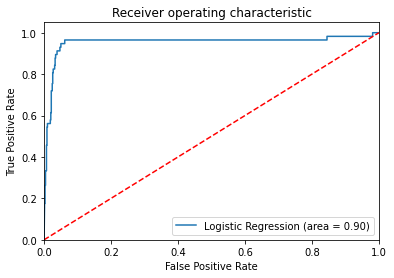

In [ ]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The confusion matrix and ROC AUC curve show approximately the same values as the previous model.

**Logistic Regression with Regularization**

Next I am going to test the LR model with the regularization.

In [ ]:
lr_reg = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5)
lr_reg.fit(train_X_trimmed, train_y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [ ]:
y_pred = lr_reg.predict(X_test_tr)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr_reg.score(X_test_tr, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       697
           1       0.66      0.82      0.73        57

    accuracy                           0.95       754
   macro avg       0.82      0.90      0.85       754
weighted avg       0.96      0.95      0.96       754



In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[673,  24],
       [ 10,  47]])

From the numbers we got which are a bit better than they were, we can draw a conclusion that regularization has slightly improved the model.

# KNN Classifier

Next, I am going to use the KNN model on the same data and compare results with what we have got from the LR model.

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski')

In [ ]:
knn_model.fit(train_X_trimmed, train_y)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
X_test_tr = X_test[cols]

In [ ]:
X_test_tr.shape

(754, 12)

In [ ]:
y_pred = knn_model.predict(X_test_tr)
print('Accuracy of KNN classifier on test set: {:.2f}'.format(knn_model.score(X_test_tr, y_test)))

Accuracy of KNN classifier on test set: 0.96


In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[681,  16],
       [ 11,  46]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       697
           1       0.74      0.81      0.77        57

    accuracy                           0.96       754
   macro avg       0.86      0.89      0.88       754
weighted avg       0.97      0.96      0.96       754



The confusion matrix and recall (f1) look slightly better than in the last variant of the LR model.

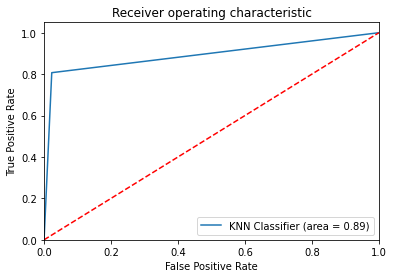

In [ ]:
knn_roc_auc = roc_auc_score(y_test, knn_model.predict(X_test_tr))
fpr, tpr, thresholds = roc_curve(y_test, knn_model.predict_proba(X_test_tr)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN Classifier (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('KNN_ROC')
plt.show()

However, the ROC AUC value is worse with the KNN model.

**Hyperparameters Tuning for KNN**

Next, I am going to use the GridSearchCV algorithm to find out the best values of hyperparameters of the KNN model. We have three of them - n_neighbors, leaf_size, and p. So GridSearch will take every value from the defined range for every hyperparameter, fit a model, compare metrics and then choose the set of hyperparameters that give the best results.

In [ ]:
leaf_size = list(range(1,10))
n_neighbors = list(range(1,16))
p=[1,2]
#Convert to dictionary
#leaf_size=leaf_size, p=p
hyperparameters = dict(n_neighbors=n_neighbors, leaf_size=leaf_size, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10, scoring='recall_micro')
#Fit the model
best_model = clf.fit(train_X, train_y)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 1


It turned out that the best value for all of the hyperparameters is 1.  

In [ ]:
# print classification report
grid_predictions = clf.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       697
           1       0.60      0.61      0.61        57

    accuracy                           0.94       754
   macro avg       0.79      0.79      0.79       754
weighted avg       0.94      0.94      0.94       754



Define the function which will draw a plot of the average score in respect of the hyperparameter value:

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('Model Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

Draw a plot reflecting the dependency between the Model Average score and the n_neighbors hyperparameter. We can see that the best performance gives us n_neighbors=1 and p=1.   

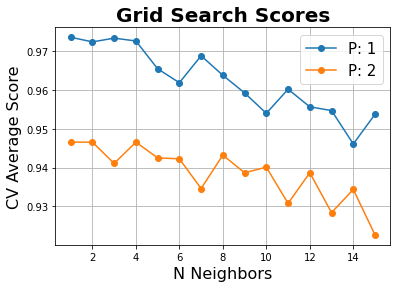

In [ ]:
# Calling Method
plot_grid_search(clf.cv_results_, n_neighbors, p, 'N Neighbors', 'P')

# Decision Tree Classifier

Next, I am going to train the Decision Tree model and compare the results with those we got using KNN and LR.

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(train_X, train_y)
y_pred = dtc.predict(X_test)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(dtc.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.97


In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[682,  15],
       [  4,  53]])

We have a few false negatives using this algorithm.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       697
           1       0.78      0.93      0.85        57

    accuracy                           0.97       754
   macro avg       0.89      0.95      0.92       754
weighted avg       0.98      0.97      0.98       754



The model performance metrics I got here are much better than were with KNN and LR classifiers. Even though I use default values for hyperparameters.

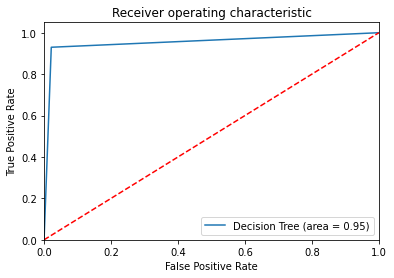

In [ ]:
dtc_roc_auc = roc_auc_score(y_test, dtc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dtc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % dtc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Dtc_ROC')
plt.show()

ROC AUC value is also quite high. <br>
So far the Decision Tree seems as the best model for our dataset. It shows the best recall for the positive class of the target. All other metrics such as accurasy, f1, and ROC AUC are also high.


# Random Forest Classifier

And finally I am going to train the Random Forest model and compare the results with previous.

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(train_X, train_y)
y_pred = rfc.predict(X_test)
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rfc.score(X_test, y_test)))

Accuracy of Random Forest classifier on test set: 0.98


In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[684,  13],
       [  4,  53]])

This model shows less false negatives and also less false positives comparing with all the previous models.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       697
           1       0.80      0.93      0.86        57

    accuracy                           0.98       754
   macro avg       0.90      0.96      0.92       754
weighted avg       0.98      0.98      0.98       754



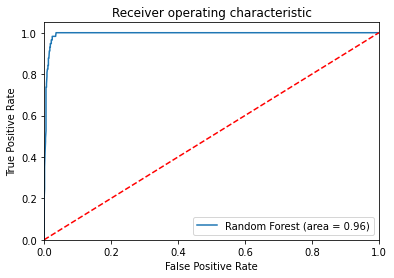

In [ ]:
rfc_roc_auc = roc_auc_score(y_test, rfc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rfc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RFC_ROC')
plt.show()

It shows the best metrics over all the algorithms I tried here. The ROC curve also has the best shape, and the ROC AUC value is the highest. I assume the Random Forest is the best model for the classification using the given dataset.    

**Conclusions:**<br>
In the process of completing this task, I prepared the data and build four different models in order to classify where the patient has a thyroid disease based on the values of the other parameters. The first model on which I did several improving techniques was Logistic Regression. In order to improve Logistic Regression performance I did an oversample of the minority class using SMOTE. Also, I did an estimate of the features' importance and feature selection using RFE. I also tried Logistic regression without regularization and with it (with different sets of hyperparameters related to the regularization). As a result of these improvements, I got the model with quite satisfying metrics (I mainly use recall and f1 for the positive class). Metrics for the negative class were quite high with all models because of the imbalance toward negatives which remains in the data. The second model I trained was KNN. It shows quite good metrics and I also did hyperparameters tuning for KNN using GridSearchCV. As the last step, I trained Decision Tree and Random Forest models and check their metrics. The best model I would choose for further tuning is Random Forest. It shows minimal False Negatives and False Positives rates and has the best metrics including ROC AUC.       